In [4]:
import pandas as pd
from models.Hermen.model_BE2 import model_BE2
import numpy as np

FBS = pd.read_csv('models/Hermen/data/FBS.csv')
QC = pd.read_csv('models/Hermen/data/QC.csv').drop(columns=['Item']).rename(columns={'FBS_item': 'Item'})
RL = pd.read_csv('models/Hermen/data/RL.csv').dropna(subset=['GGI_code'])

QC = QC.groupby(['Item', 'GGI_code', 'Year', 'Area']).mean().reset_index()

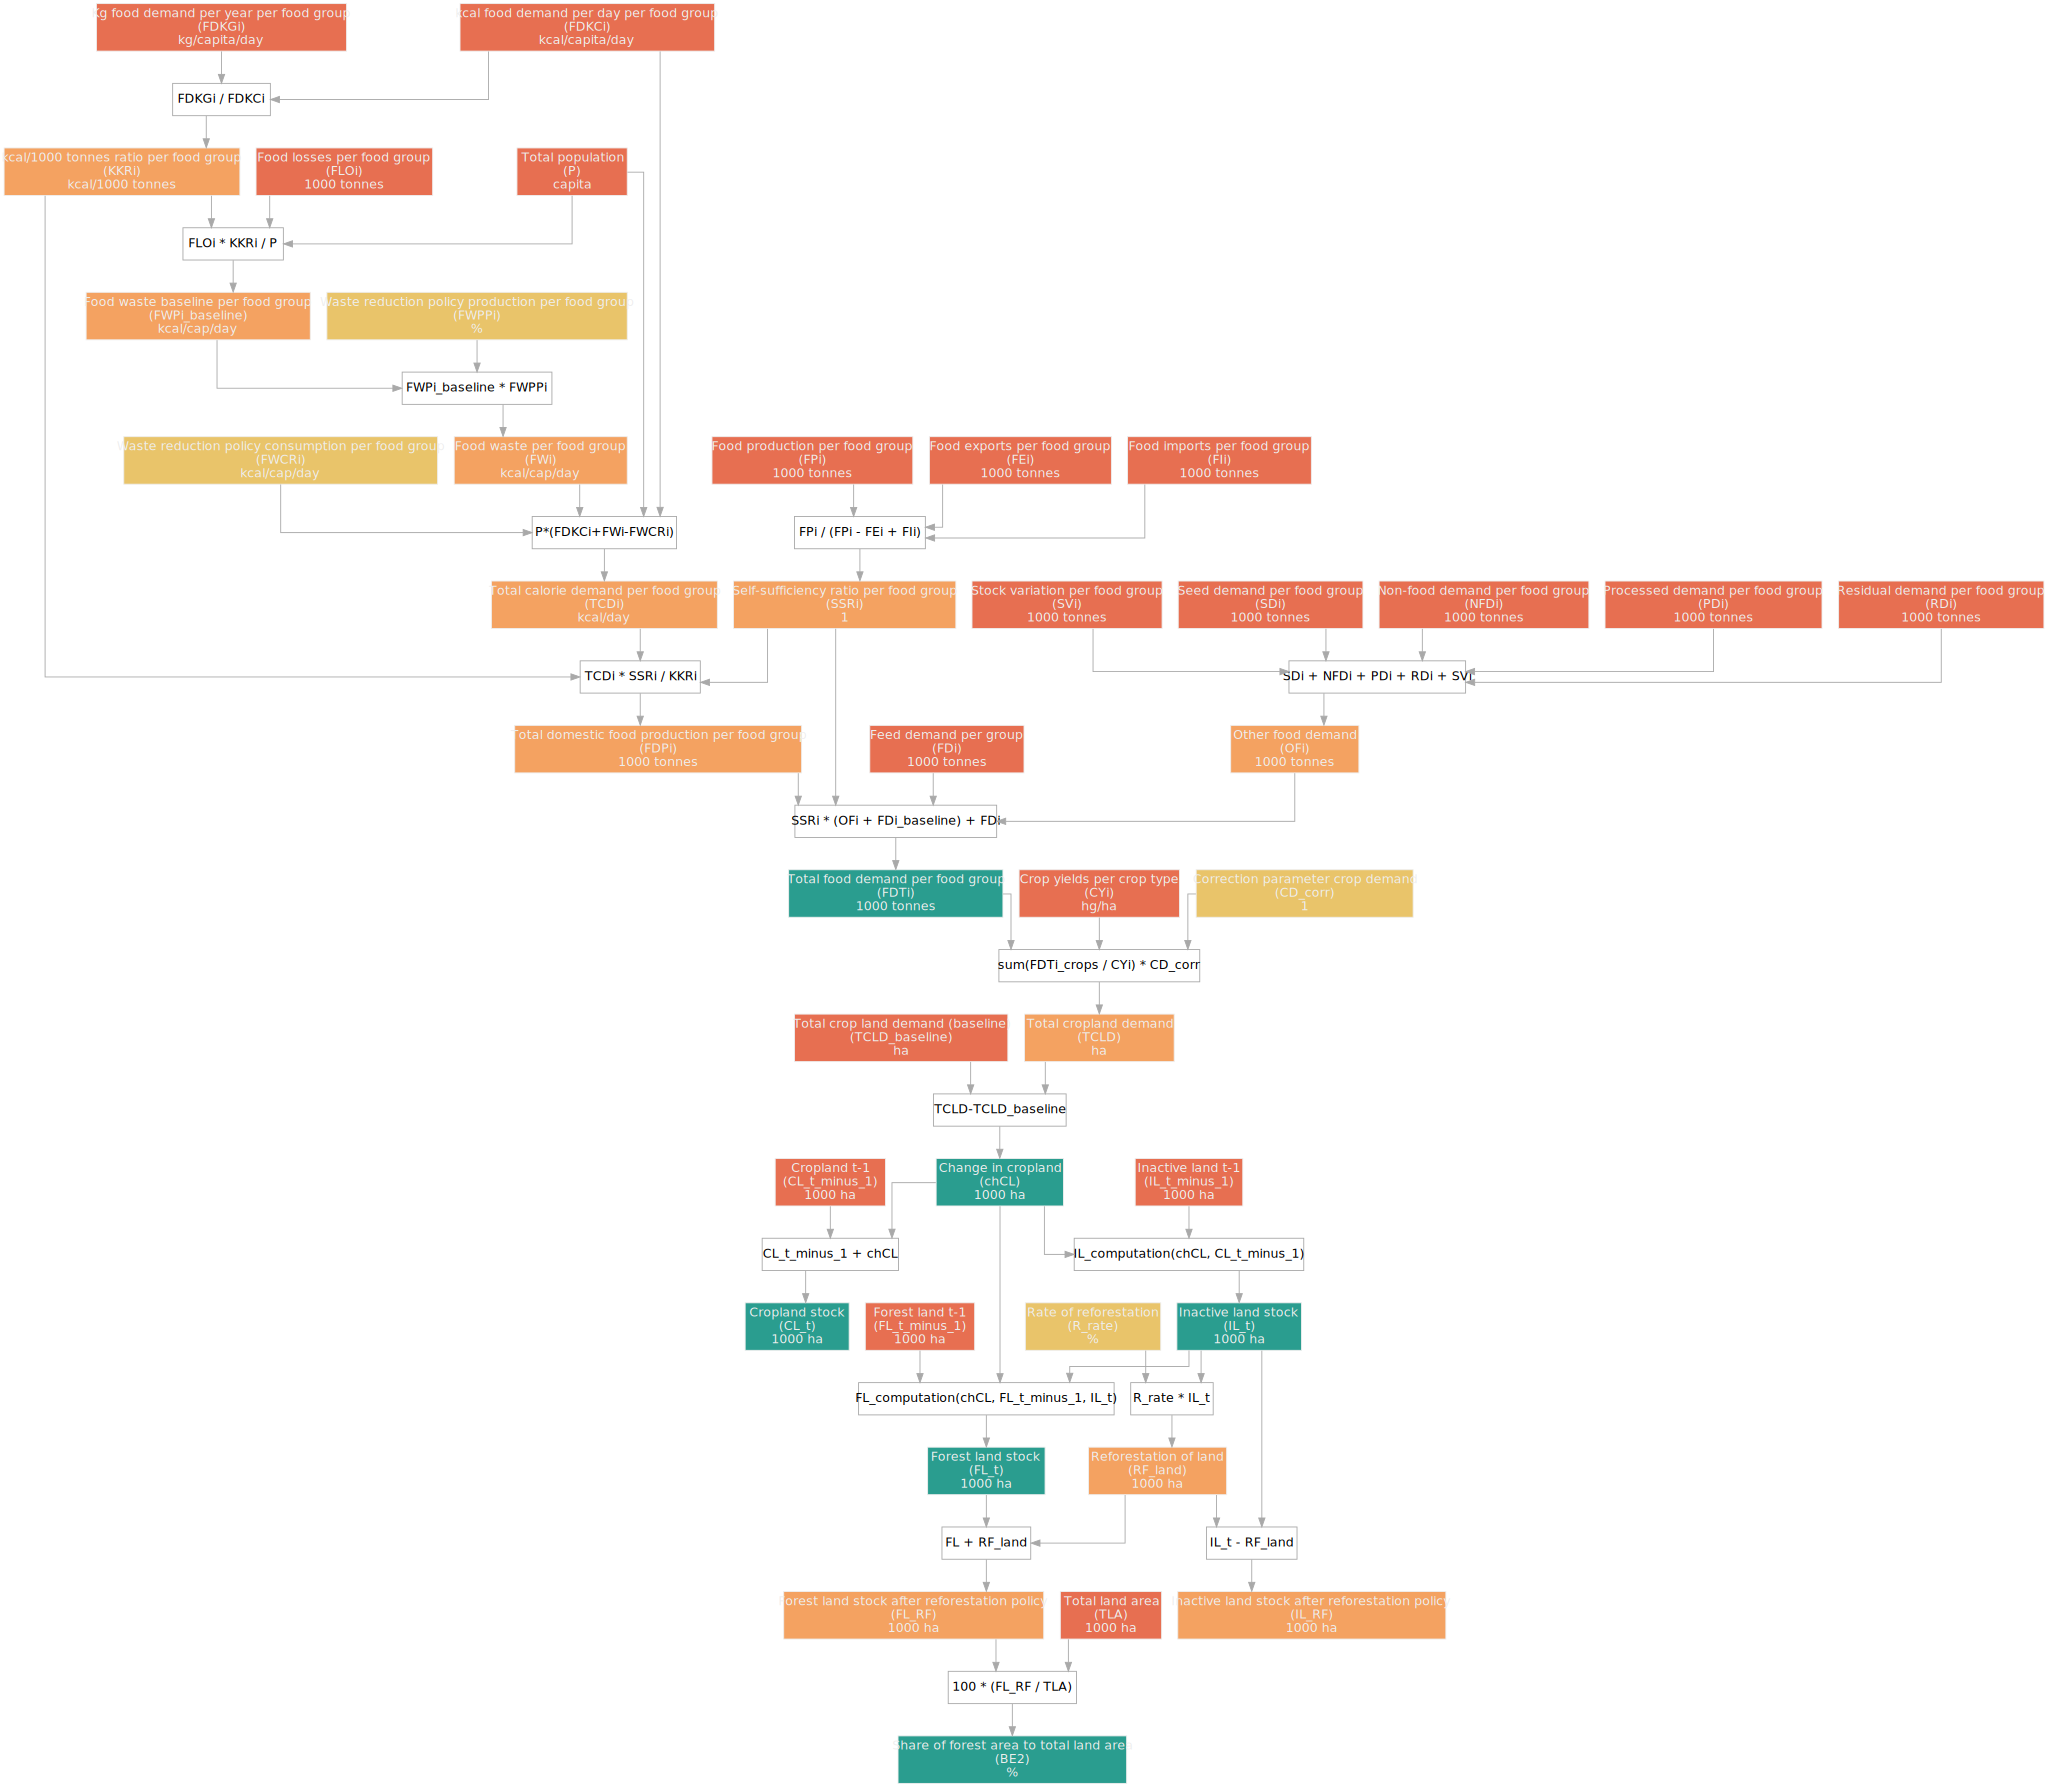

In [5]:
model_BE2.draw()

In [6]:
model_BE2.summary_df

,name,type,unit,computation
id,,,,
TLA,Total land area,input,1000 ha,NaN
FL_t,Forest land stock,input,1000 ha,NaN
IL_t,Inactive land stock,input,1000 ha,NaN
R_rate,Rate of reforestation,parameter,%,NaN
RF_land,Reforestation of land,variable,1000 ha,R_rate * IL_t
FL_RF,Forest land stock after reforestation policy,variable,1000 ha,FL + RF_land
IL_RF,Inactive land stock after reforestation policy,variable,1000 ha,IL_t - RF_land
BE2,Share of forest area to total land area,output,%,100 * (FL_RF / TLA)
chCL,Change in cropland,input,1000 ha,NaN


In [7]:
# Aux functions, to improve. The idea is to run the model on the full database at once rather than spliiting all the stuff. Perharps using dataframe around
def pivot(df):
    return df.pivot(index=['Area', 'Year','Item'], columns='GGI_code', values='Value')

def df_to_dict(df):
    X = {}
    for code in df.columns:
        X[code] = df[code].fillna(0)
    return X

def FBS_QC_RL_to_X(FBS, QC, RL):
    
    
    X = {}
    
    FBS_dict = df_to_dict(pivot(FBS))
    QC_dict = df_to_dict(pivot(QC))
    RL_dict = RL[['Area', 'Year', 'GGI_code', 'Value']].pivot(index=['Area', 'Year'], columns='GGI_code', values='Value')
    RL_dict = df_to_dict(RL_dict)
    
    for dictionnary in [FBS_dict, QC_dict, RL_dict]:
        X.update(dictionnary)
    
            
    crop_group = FBS.dropna()[FBS.dropna()['group'] == 'crop'].Item.unique()
    animal_group = FBS.dropna()[FBS.dropna()['group'] == 'animal'].Item.unique()
    
    X['P'] = X['P'].dropna()
    X['crop_group'] = crop_group
    X['animal_group'] = animal_group

    X['FWPPi'] = 100
    X['FWCRi'] = 0
    X['CRfd'] = 1
    X['CD_corr'] = 1
    X['R_rate'] = 0

    
    # To clean up
    FDi = X['FDi'].reset_index('Item')

    # to check
    X['TCLD_baseline'] = X['TCLDi'].groupby(level=['Area', 'Year']).sum()
    
    X['FMi'] = X['FDi'].loc[:, :, crop_group] / X['FDi'].loc[:, :, crop_group].groupby(level=['Area', 'Year']).sum()
    
    X['P'] = X['P'].reset_index('Item', drop=True).drop_duplicates()
    

    return X


X = FBS_QC_RL_to_X(FBS, QC, RL)

In [8]:
res = model_BE2.run(X)

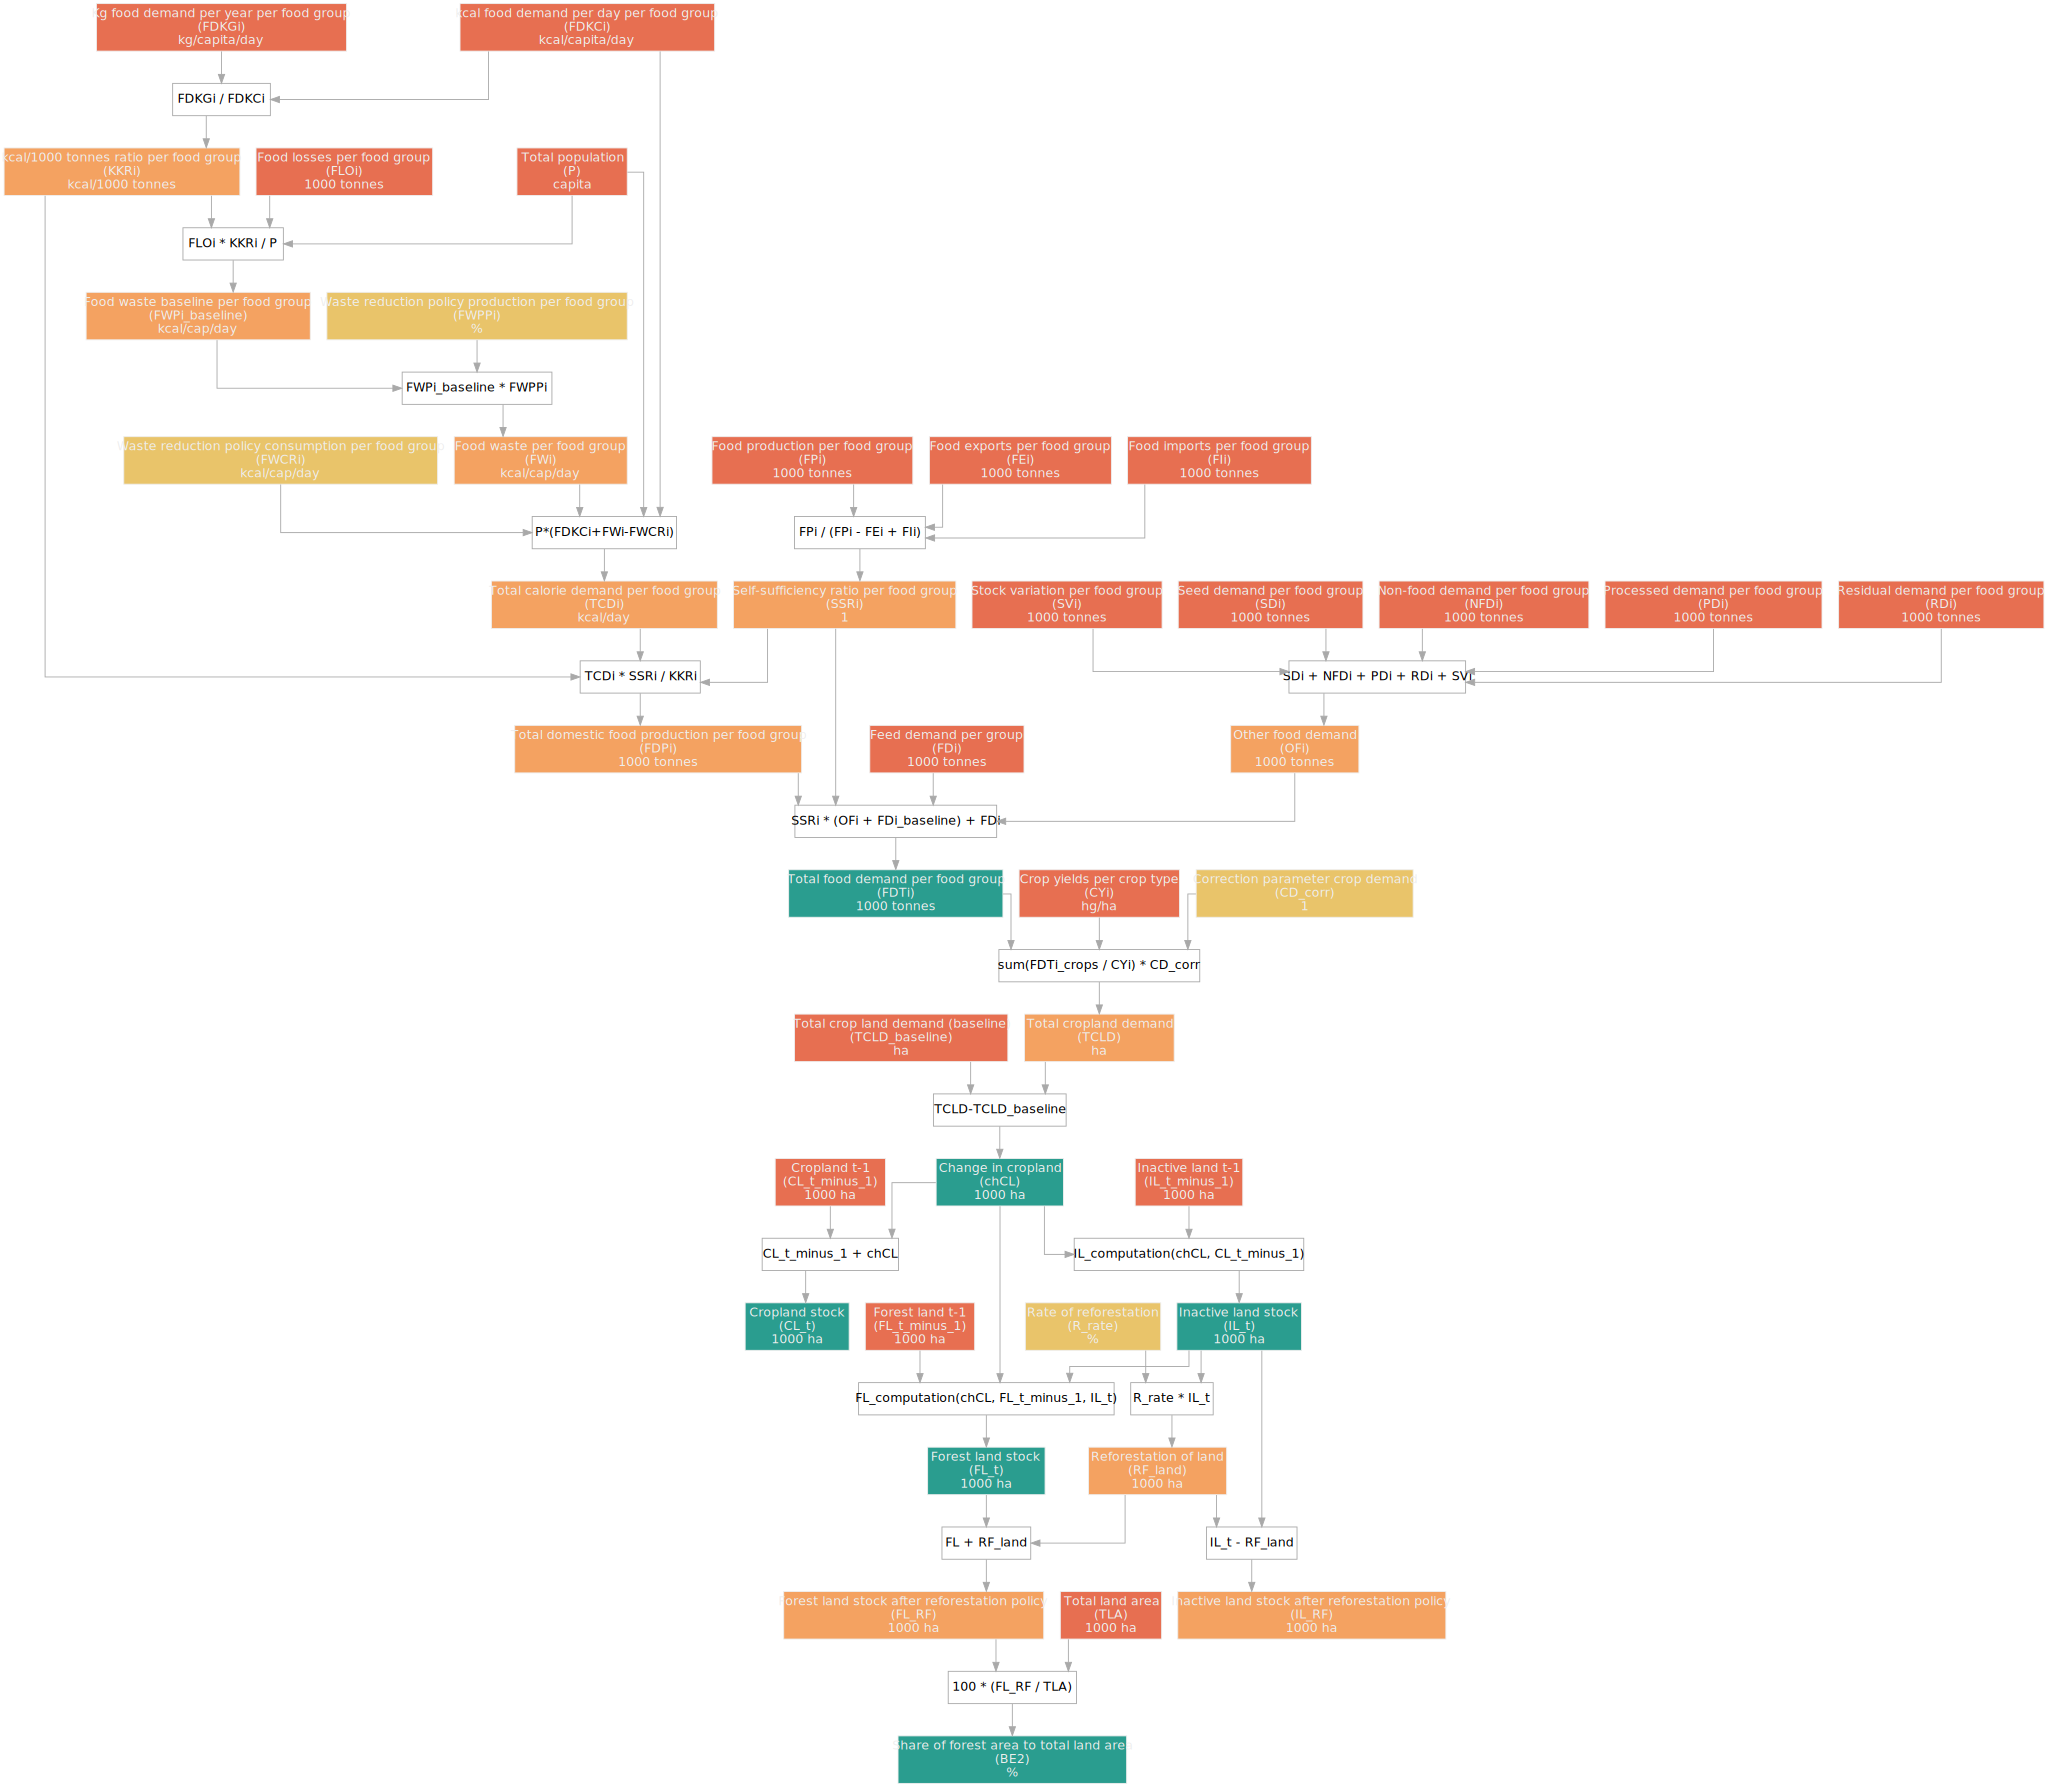

In [12]:
model_BE2.draw()

In [13]:
(res['FDTi'] / res['FPi']).loc['France', :]

Area    Year  Item               
France  2014  Alcohol, Non-Food           NaN
              Alcoholic Beverages    0.999982
              Animal Products             NaN
              Animal fats            1.000005
              Apples and products    0.999240
                                       ...   
        2018  Vegetables, Other      0.999911
              Vegetal Products            NaN
              Wheat and products     1.000041
              Wine                   0.999938
              Yams                        NaN
Length: 575, dtype: float64